<!-- JPN -->
# ニューラルネットワークによる多クラス分類

※本演習資料の二次配布・再配布はお断り致します。


<!-- ENG -->
# Multi class classification using neural network
※Distribution or redistribution of these exercise materials without the copyright holder's permission is not permitted.


<!-- JPN -->
　ニューラルネットワークでは、これまで学んできた線形回帰、多項式回帰、ロジスティック回帰などに比べて、予測方法の設計の自由度が高く、それが故に考慮しなければならない事項も多く存在する。以下の3つに絞る形で、演習で紹介する。

- **1 | 事前準備**
- **2 | MNISTを用いた多クラス分類**
- **3 | 勾配消失問題とその対策**
- **4 | Dropoutによる正則化**

<!-- ENG -->
　With neural networks, there is more freedom in designing prediction methods than in linear regression, polynomial regression, and logistic regression, which we have studied so far, and therefore there are more things to consider. The exercises will be introduced in the following three ways.

- **1 | Advance preparations**
- **2 | Multi-class classification using MNIST**
- **3 | Vanishing gradient problem and its countermeasures**
- **4 | Regularization using Dropout**

<!-- JPN -->
## 1 | 事前準備

<!-- ENG -->
## 1 | Advance preparations

<!-- JPN -->
### 1.1 | 手書き文字 MNIST の準備

<!-- ENG -->
### 1.1 | Preparing handwritten text MNIST

<!-- JPN -->
　今回は手書き文字 MNIST に対する学習を題材に、ニューラルネットワークによる多クラス分類 (multi-class classification) を学んでいく。MNIST は有名なデータセットで、様々な人が機械学習（特にニューラルネットワーク）のテスト実行の題材として利用している。

　PyTorchには、 `torchvision` という画像処理向けのライブラリが別途用意されており、これを使うことでMNISTデータを自動的に処理することができる。

<!-- ENG -->
　Here, we will learn multi-class classification with handwritten digits MNIST. MNIST is a very well known data set that is used by many people as a subject for test runs in machine learning, especially neural networks.

　PyTorch has a separate library for image processing, called `torchvision`, which can be used to automatically process MNIST data.

In [1]:
import numpy as np
import torch
import torchvision

trainset = torchvision.datasets.MNIST(root=".", train=True, download=True, transform=torchvision.transforms.ToTensor())
testset  = torchvision.datasets.MNIST(root=".", train=False, download=True, transform=torchvision.transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 130257883.46it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 79070296.23it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 54027024.85it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 18955750.02it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [2]:
# torch.tensor -> numpy.array
X_train = trainset.data.numpy()
y_train = trainset.targets.numpy()
X_test = testset.data.numpy()
y_test = testset.targets.numpy()

# scaled from [0,255] to [0,1] for X
X_train = X_train / 255
X_test  = X_test / 255

<!-- JPN -->
　torchvisionの `torchvision.datasets.MNIST` 関数は `torch.tensor` に自動的に変換してくれるのだが、中身のデータを目視で確認するために、一旦 `numpy.array` に変換した。

<!-- ENG -->
　The `torchvision.datasets.MNIST` function of torchvision automatically converts the data sets to `torch.tensor`, but I temporarily converted it to `numpy.array` to visually check the content of the data.

<!-- JPN -->
　MNISTのデータは、以下のような件数のデータが含まれている。

<!-- ENG -->
　The MNIST contains the following types of data.

<!-- BOTH -->

+ `X_train`: $60000 \text{ (images)} \times 28 \text{ (rows)} \times 28 \text{ (columns)}$
+ `y_train`: $60000 \text{ (labels)}$
+ `X_test`: $10000 \text{ (images)} \times 28 \text{ (rows)} \times 28 \text{ (columns)}$
+ `y_test`: $10000 \text{ (labels)}$


<!-- JPN -->
　実際にPythonのコードを書いて確認してみよう。

<!-- ENG -->
　Let's actually write some Python code to check it out.

In [3]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


<!-- JPN -->
　次に、MNISTの画像について、いくつか描画してみよう。
`i` の値を書き換えることで、いろいろな手書き文字を見ることができる。
また、各座標には0.0から1.0までの値が記述されているが、これが入力特徴量になる。

<!-- ENG -->
　Next, let's try to draw some MNIST images.
By rewriting the value of `i`, we can see various handwritten texts.
In addition, each coordinate is described by a value from 0.0 to 1.0, which will be the input feature value.

5


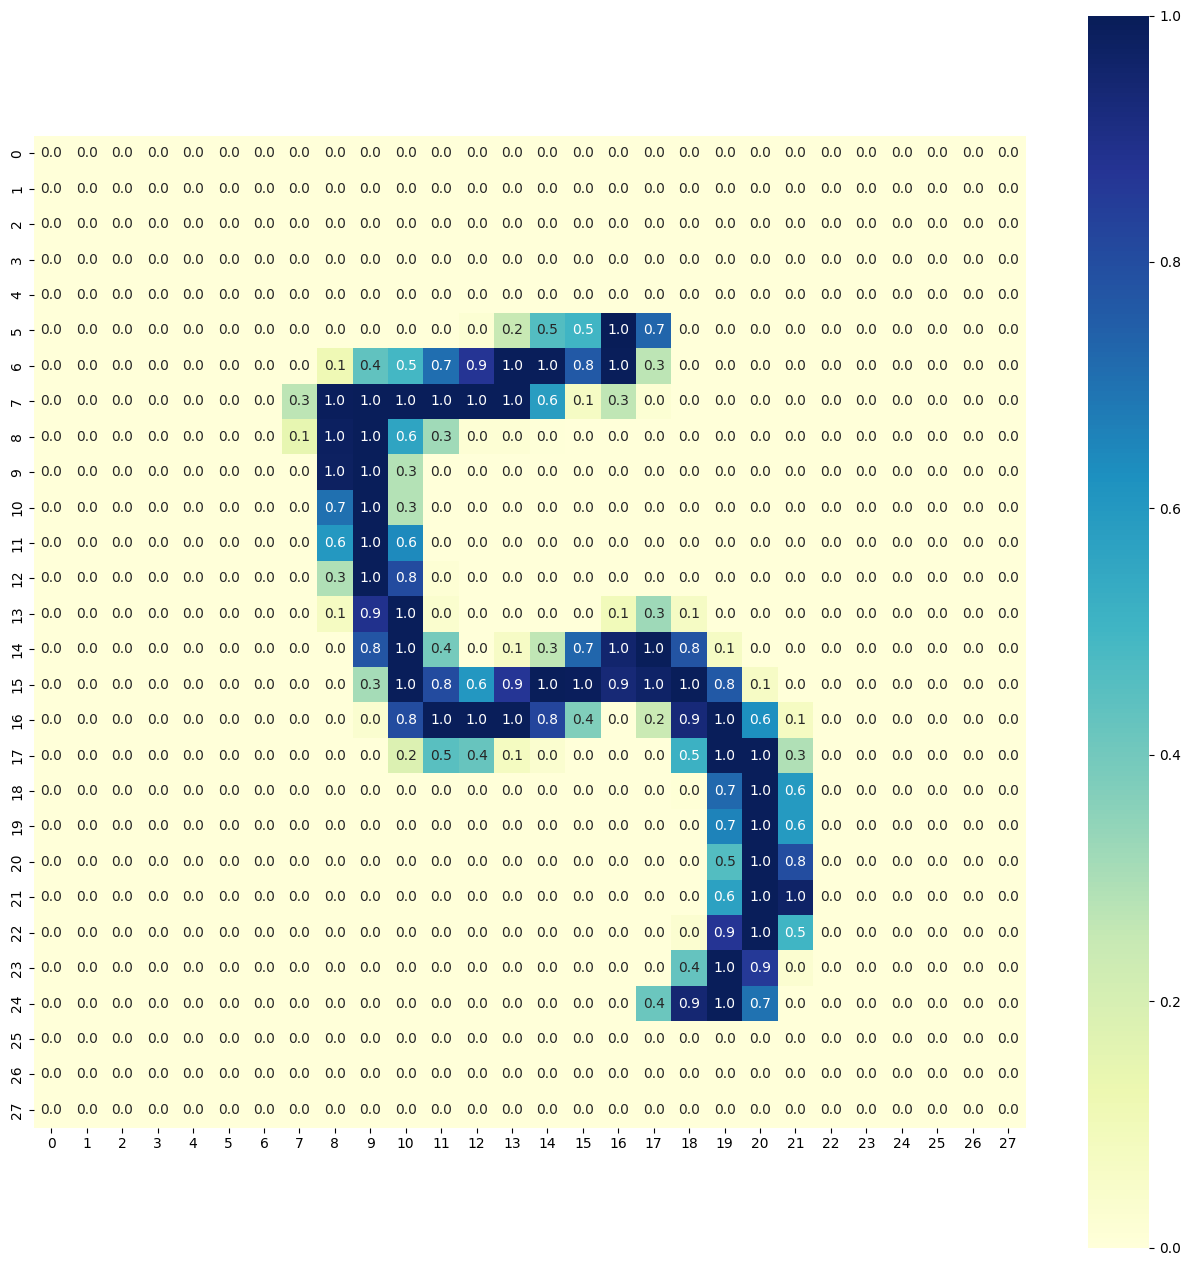

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Index number of an instance (change this to view another instance).
i = 1024

image = X_train[i]
label = y_train[i]

print(label)
plt.figure(figsize=(16, 16))
sns.heatmap(image, annot=True, fmt='.1f', square=True, cmap="YlGnBu")
plt.show()

<!-- JPN -->
　ちなみに、MNISTデータは癖の少ない、非常にキレイな（予測しやすい）データである。1文字が左右上下に偏ることもなく、文字のサイズが大きく異なることもなく、また文字以外のノイズもほとんど見当たらない。このような**データのきれいさ (data cleanliness)** は機械学習全般においてとても重要である。

<!-- ENG -->
　Incidentally, MNIST data is very clean (and predictable) and has few quirks. No single character is biased to the left, right, top, or bottom, no characters vary greatly in size, and there is almost no non-character noise. This kind of **data cleanliness** is very important in machine learning in general.

<!-- JPN -->
### 1.2 | livelossplotのインストール

　今回のMNISTは6万件ものデータが含まれているため、学習にそれなりの時間がかかる。リアルタイムで学習の状況を見る1つの方法として、livelossplotというものを利用してみる。

　livelossplotは初期状態ではGoogle Colaboratoryにインストールされていないので、以下のコマンドを利用してインストールを行う。

<!-- ENG -->
### 1.2 | Installation of livelossplot

　This time, MNIST contains 60,000 items of data, so it takes a lot of time to train. Here, we use livelossplot, which is a tool to see how the training works.

　Since livelossplot is not installed in Google Colaboratory by default, use the following command to install it.

In [5]:
# Note that the following command is not a Python command, but a Google Colab-specific method.
# The Python package management tool called pip is used to install livelossplot.
!pip install livelossplot

<!-- JPN -->
　色々な文字列が出て来るが、最終的に **"Successfully installed ..."** のような記述がされていればインストールは完了である。（もし **"Requirement already satisfied"** で終わっていたら、既にインストールは完了していると考えてよい）

<!-- ENG -->
　Although various text strings will be displayed, installation is complete when the message **"Successfully installed ..."** appears. (if the message ends with **"Requirement already satisfied"**, you can assume that the installation is already complete.)

<!-- JPN -->
## 2 | MNISTを用いた多クラス分類

<!-- ENG -->
## 2 | Multi-class classification using MNIST

<!-- JPN -->
　今回使うMNISTは**0から9までの10種類の数字があり、それぞれを予測する**。このように、3つ以上のクラスの中からどれか1つを選ぶような予測をすることを**多クラス分類 (multi-class classification)** と呼ぶ。

　2クラス分類の時には、入力 $\boldsymbol{x}$ に対応する予測値 $\hat{y}$ はスカラ量であり、クラス1（○）である確率を出力していた。
しかし、 $K$ クラス分類の場合は、予測値は $K$ 次元のベクトル $\hat{\boldsymbol{y}}=[\hat{y}_1, \hat{y}_2, ..., \hat{y}_K]$ にして、$\hat{y}_i$は入力 $\boldsymbol{x}$ がクラス $i$ である確率と考える。

<!-- ENG -->
　MNIST which we will be using **has 10 different number characters from "0" to "9", and predicts each of them.** This kind of single prediction from three or more options is called **multi-class classification**.

　In the two-class classification, the predicted value $\hat{y}$ corresponding to the input $\boldsymbol{x}$ is a scalar quantity, and the probability of being class 1 (correct) was output.
However, in the case of $K$-class classification, the predicted value is a $K$-dimensional vector $\hat{\boldsymbol{y}}=[\hat{y}_1, \hat{y}_2, ..., \hat{y}_K]$, where $\hat{y}_i$ is the probability that the input $\boldsymbol{x}$ is class $i$.

<!-- JPN -->
### 2.1 | PyTorchのためのデータ準備

<!-- ENG -->
### 2.1 | Preparing data for PyTorch

<!-- JPN -->
　それでは、実際に学習を行うために、いろいろな作業を行おう。最初に、`X_train`, `y_train`を`X_train`, `X_valid`, `y_train`, `y_valid`に分割する（training-validation分割）。

<!-- ENG -->
　Now, let's do some work to actually carry out the training. First, split `X_train` and `y_train` into `X_train`, `X_valid`,`y_train`, and `y_valid` (training-validation split).

In [6]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split

In [7]:
# Split the train into 50,000 training data and 10,000 validation data
# Assign random_state=0 so that the result of splitting will be the same every time
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,
                                                      train_size=50000, random_state=0)

# Use test as is

<!-- JPN -->
　続いて、 `X` をPyTorch用のデータに変換する。`X` は先ほど見たように2次元状にデータが並んでいるが、通常のニューラルネットワークは2次元形式で与えられても処理できないため、$28 \times 28 = 784$ の要素がある1次元配列に変換し、それからPyTorch形式に変換する。

<!-- ENG -->
　Then convert  `X` into data for PyTorch. As we saw earlier, the data for `X` is arranged in a two-dimensional state, but a normal neural network cannot process data given in a two-dimensional format, so we must convert it to a one-dimensional array with $28 \times 28 = 784$ elements, and then convert it to PyTorch format.

<img src="https://i.imgur.com/mDFvkhK.png" width="50%" alt="Figure 1">

In [8]:
X_train_flatten = X_train.reshape(50000, 28*28) # Convert 50,000 2D images (28x28) into 50,000 1D data (784)
X_valid_flatten = X_valid.reshape(10000, 28*28)
X_test_flatten  = X_test.reshape(10000, 28*28)

In [9]:
X_train_torch = torch.tensor(X_train_flatten, dtype=torch.float) # Don't forget dtype=torch.float
X_valid_torch = torch.tensor(X_valid_flatten, dtype=torch.float)
X_test_torch  = torch.tensor(X_test_flatten,  dtype=torch.float)

<!-- JPN -->
　次に、$y$ をPyTorch用のデータ形式にする。今回は多クラス分類であり、0~9のどれかを予測することから、yの値は確率を表す実数値 `float` ではなく、整数値 `long` で表現されていることに気を付けてほしい。

<!-- ENG -->
　Next, put $y$ into a data format for PyTorch. Since this is a multi-class classification and we are predicting a value between 0~9, please note that the value of y is expressed as a integer value `long`, not a real number `float` that represents probability.

In [10]:
y_train_torch = torch.tensor(y_train, dtype=torch.long) # Don't forget dtype=torch.long
y_valid_torch = torch.tensor(y_valid, dtype=torch.long)
y_test_torch  = torch.tensor(y_test,  dtype=torch.long)

<!-- JPN -->
　これで基本準備ができた。そうしたら、あとは前回と同様にdatasetとdataloaderを定義して、モデルを作って学習を行ってみるだけだ。ただし、datasetとdataloaderはtrainだけではなくvalid, testも別に用意しよう。

<!-- ENG -->
　Now we have completed the basic preparations. After that, all you have to do is define the data set and dataloader as before, create a model, and train a model. However, the data set and dataloader should be prepared not only for train, but also for valid and test respectively.

In [11]:
# A useful way that retains the combination of X and Y
train_dataset = torch.utils.data.TensorDataset(X_train_torch, y_train_torch)
valid_dataset = torch.utils.data.TensorDataset(X_valid_torch, y_valid_torch)
test_dataset  = torch.utils.data.TensorDataset(X_test_torch,  y_test_torch)

In [12]:
# PLEASE DO NOT CHANGE THIS BATCH SIZE because it affects the result of the assignments
batch_size = 256 # This time, we will train for each of the 256 data items

# A convenient way to output in (batch_size) batches combinations of X and Y
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size)

<!-- JPN -->
　上記のコードでは、 `batch_size=256` のミニバッチ学習を行えるようにした。この場合、 `for X, y in train_loader` とすると、256件ずつデータが出力される。

　バッチサイズは $2^n$ を使うことが慣例的に多く、またバッチサイズを大きくするほど学習は安定するが、「まあまあ」な重みパラメータ付近で安定してしまい、**より良いパラメータにたどり着けないこともある**。このために**バッチサイズを16程度にすることもあれば、1024以上の値にすることもある**など、その値はまちまちである。

<!-- ENG -->
　In the above code, I made it possible to perform mini-batch training with `batch_size=256`. In this case,  256 data items can be output by using `for X, y in train_loader` statement.

　It is customary to use  $2^n$ for the batch size, and the larger the batch size, the more stable the training will be, but it will be stable near the "fair" weight parameter, and **it also may not be possible to reach a “better” parameter**. For this purpose, **the batch size may be as small as 16 or as large as 1024 or more, etc.** The value may vary.

<!-- JPN -->
### 2.2 | MNISTの学習の実行

　それでは、ここまでに作成した `DataLoader` を利用して、学習を行ってみる。ここでは、モデル `model` 、損失関数 `loss_fn`、および最適化手法 `opt` を引数とすることで、汎用的に学習や予測を行えるコードを作成してみる。

　作ろうとするコードは多少複雑になるので、これからやることを、まず箇条書きする。

1. 訓練データ `train_loader` を用いてモデルのパラメータを更新する。その時に、訓練損失（訓練データに対する損失関数の値）と訓練データに対する予測精度を保存しておく。
2. 検証データ `valid_loader` を用いて、現在のモデルがどの程度の汎化性能 / 汎化損失を持つか推定する。
3. `liveloss` を利用して、1.および2.で計算した損失および精度を描画する。
4. 1.から3.をepoch数だけ繰り返す。

箇条書きをしたら、それに対応するコードを関数として記述してみよう。


<!-- ENG -->
### 2.2 | Run MNIST training

　Now, let's try training using the `DataLoader` that we have created so far. In this section, we will try to create a code that can perform general-purpose training and prediction by using a `model`, loss function `loss_fn`, and optimization method `opt` as arguments.

　The code we're going to create will be somewhat complex, so let's see the list of what we're going to do.

1. Update the parameters of the model using the training data `train_loader`. At that time, save the training loss (loss function value for the training data) and the prediction accuracy for the training data.
2. Estimate the generalization performance / generalization loss of the current model using the `valid_loader` validation data.
3. Use `liveloss` to draw the loss and accuracy calculated in 1. and 2.
4. Repeat steps 1 through 3 for the number of epochs.

After checking the list, let's write the corresponding code as a function.


In [13]:
import torch
from livelossplot import PlotLosses

In [14]:
# Corresponding to step 1
def update_model(model, loss_fn, opt, train_loader):
  train_loss = 0
  train_correct = 0
  train_count = len(train_loader.dataset)

  for X, y in train_loader:
    y_pred = model(X) # Predict y from X (the value before softmax is performed is output)

    _, predicted = torch.max(y_pred.data, 1) # Get the class number with the highest prediction probability out of the 10 classes
    train_correct += (predicted == y).sum().item() # Count the number of successful predictions (for accuracy calculation)

    loss = loss_fn(y_pred, y)        # Calculate the average of the training losses in a mini-batch
    train_loss += loss.item()*len(y) # Calculate the total training loss for the entire epoch

    # Update weights
    opt.zero_grad()
    loss.backward()
    opt.step()

  # Calculate the average training loss and prediction accuracy within an epoch
  mean_train_loss = train_loss / train_count
  train_accuracy = train_correct / train_count

  return mean_train_loss, train_accuracy

In [15]:
# Corresponding to step 2
def evaluate_model(model, loss_fn, dataloader):
  model.eval() # Set to “evaluate” state when training is not performed (Supplementary Material S1)

  valid_loss = 0
  valid_correct = 0
  valid_count = len(dataloader.dataset)

  for X, y in dataloader:
    y_pred = model(X) # Predict y from X (the value before softmax is performed is output)

    _, predicted = torch.max(y_pred.data, 1) # Get the class number with the highest prediction probability out of the 10 classes
    valid_correct += (predicted == y).sum().item() # Count the number of successful predictions (for accuracy calculation)

    loss = loss_fn(y_pred, y)        # Calculate the average of the training losses in a mini-batch
    valid_loss += loss.item()*len(y) # Calculate the total training loss for the entire epoch

  mean_valid_loss = valid_loss / valid_count
  valid_accuracy = valid_correct / valid_count

  model.train() # Return from the “evaluate” state to the “train” state
  return mean_valid_loss, valid_accuracy

In [16]:
# Corresponding to step 3. and step 4.
def train(model, loss_fn, opt, train_loader, valid_loader, epoch=50):
  liveloss = PlotLosses() # Initialize the drawing
  for i in range(epoch):
    train_loss, train_accuracy = update_model(model, loss_fn, opt, train_loader)
    valid_loss, valid_accuracy = evaluate_model(model, loss_fn, valid_loader)

    # Visualize the loss and accuracy values.
    liveloss.update({
        'loss': train_loss,
        'val_loss': valid_loss,
        'accuracy': train_accuracy,
        'val_accuracy': valid_accuracy,
    })
    liveloss.draw()
  print('Accuracy: {:.4f} (valid), {:.4f} (train)'.format(valid_accuracy, train_accuracy))
  return model # Return the trained model

<!-- JPN -->
最後に単層パーセプトロンのモデルを作成する。

<!-- ENG -->
The last step is to create a model of a single-layer perceptron.

In [17]:
torch.manual_seed(0) # Ensure reproducibility of training results

slp = torch.nn.Sequential(
    torch.nn.Linear(28*28, 10) # 10-class classification, so output is 10-dimensional
)

# Prepare loss functions and optimization methods
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(slp.parameters(), lr=0.1)

<img src="https://i.imgur.com/k4anVIY.png" alt="Figure 2" width="25%">

<!-- JPN -->
**単層パーセプトロン** | 最後のsoftmaxは `torch.nn.CrossEntropyLoss()` の中で定義されている。

<!-- ENG -->
**Single-layer perceptron** | The last softmax is defined in `torch.nn.CrossEntropyLoss()`.

<!-- JPN -->
　$\mathrm{softmax}$ は $\mathrm{sigmoid}$ 関数 $\sigma(\cdot)$ の多クラス分類への拡張であり、以下の式で表すことができる。

<!-- ENG -->
　$\mathrm{softmax}$ is an extension of the $\mathrm{sigmoid}$ function $\sigma(\cdot)$ to multi-class classification and can be expressed by the following equation.

$$\begin{aligned}
\mathrm{softmax}{(\boldsymbol{z})}_k & = \frac{e^{z_k}}{\sum^9_{i=0}e^{z_i}}
\end{aligned}$$

<!-- JPN -->
この $\mathrm{softmax}$ で変換された $\hat{y}_k$ は**確率の要件である $0 \le \hat{y}_k \le 1$ かつ $\sum_k \hat{y}_k = 1$
を満たす**ので、入力されたデータが0~9のどの数字と思われるか、の予測確率であると考えることができる。

　また、交差エントロピー損失 `torch.nn.CrossEntropyLoss()` についても多クラス分類の拡張が行われている。

<!-- ENG -->
This $\mathrm{softmax}$-transformed $\hat{y}_k$ **satisfies the probability requirements $0 \le \hat{y}_k \le 1$ and $\sum_k \hat{y}_k = 1$**, so we can think of it as the predicted probability that the input data will be like any number from 0~9.





　Cross entropy loss `torch.nn.CrossEntropyLoss()` has also been extended for multi-class classification.

$$\begin{aligned}
H(y, \hat{\boldsymbol{y}}) & = -\left(\sum^9_{k=0} y_k\log\hat{y}_k\right) \\
y_k & = \left\{
\begin{array}{l}
      0~(y\ne k) \\
      1~(y=k)
    \end{array}
  \right.
\end{aligned}$$

<!-- JPN -->
上記の $y_k$ のように、$y=2$ を $[0,0,1,0,0,...]^T$ とベクトルで表現したものを **one-hot vector** と呼ぶ（1か所だけ非ゼロの値になっていることを one-hot と表現している）。
$H(y, \hat{\boldsymbol{y}})$は総和で記述されているが、one-hot vectorの特性から $H(y, \hat{\boldsymbol{y}}) = -\log\hat{y}_y$ で計算できる。



<!-- ENG -->
As seen in $y_k$ above, the vector representation of $y=2$ as $[0,0,1,0,0,...]^T$ is called a **one-hot vector** (that only one place has a non-zero value, which is expressed as one-hot).
Although $H(y, \hat{\boldsymbol{y}})$ is described as a sum, it can be calculated by $H(y, \hat{\boldsymbol{y}}) = -\log\hat{y}_y$ from the characteristics of one-hot vector.



<!-- JPN -->
　それでは、学習を行ってみよう。数分かかるが、epoch数が増えるにしたがって予測精度が変化していく様を見ると面白い。

<!-- ENG -->
　Now let's do some training. It takes a few minutes, but it is interesting to see how the prediction accuracy changes as the number of epochs increases.

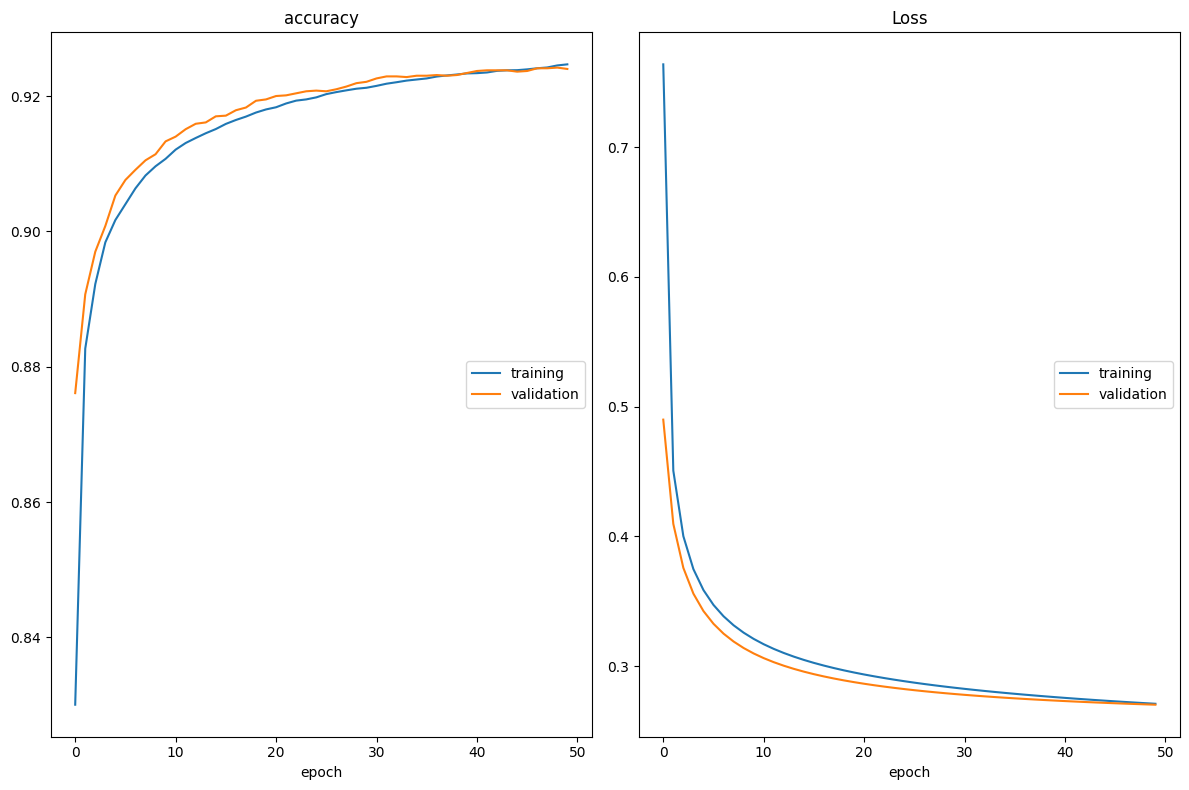

accuracy
	training         	 (min:    0.830, max:    0.925, cur:    0.925)
	validation       	 (min:    0.876, max:    0.924, cur:    0.924)
Loss
	training         	 (min:    0.271, max:    0.764, cur:    0.271)
	validation       	 (min:    0.270, max:    0.490, cur:    0.270)
Accuracy: 0.9240 (valid), 0.9247 (train)


In [18]:
# Run training
trained_model = train(slp, loss_fn, optimizer, train_loader, valid_loader)

<!-- JPN -->
　最後に作成されたモデルを使って、テストデータを予測してみよう（本当は検証 (validation) データで精度最大であったようなepochの時のモデルを利用すべきなのだが、ここでは50epoch後のモデルを使ってテストデータの予測を行う）。

<!-- ENG -->
　Finally, let's use the created model to predict the test data. (In fact, we should use the model at the time of the epoch where the validation data had maximum accuracy, but here we will use the model after 50 epochs to predict the test data).

In [19]:
test_loss, test_accuracy = evaluate_model(slp, loss_fn, test_loader)
print(test_loss)
print(test_accuracy)

0.274080428647995
0.9225


<!-- JPN -->
　どうやら、単層パーセプトロンを用いてだいたい92%程度の予測が行えるようだ。

<!-- ENG -->
　Apparently, it is possible to make predictions with roughly 92% accuracy using a single-layer perceptron.

<!-- JPN -->
### 2.3 | GPU (Graphics Processing Unit) を用いた計算

<!-- ENG -->
### 2.3 | Calculation using a GPU (Graphics Processing Unit)

<!-- JPN -->
　ここまでは、前回の授業と同様の設定で学習を行ってきた。しかし、ここから先は一気に計算量が増え、このままでは計算時間を大量に必要としてしまう。そんな時に、大きな力となるのが **GPU (Graphics Processing Unit) という部品**である。 この部品は Graphics の名前の通り、本来は**画面描画用のパーツ**であるが、これが近年の深層学習の発展に無くてはならない部品となっている。

<!-- ENG -->
　Until here, we have been training the model in the same way as in the previous lecture. However, the calculation cost will dramatically increase in the next section. In such a situlation, **a component called the GPU (Graphics Processing Unit)** can be a great help. As the name "Graphics" implies, **this is essentially a screen drawing part**; however, It has become an essential component in the recent development of deep learning.

<!-- JPN -->
このパーツを天体や流体、タンパク質などのシミュレーションなど、描画以外に転用することで、計算を高速化することができる。このGPUを使うことで、**ニューラルネットワークの計算の（数倍から10倍以上の）高速化**が達成できる。
Google Colaboratoryでは、GPUを無料で使うことができる（**補足資料 ※2**）ので、これを用いた計算を行ってみる。

<!-- ENG -->
These parts can be used for other purposes than drawings, such as simulation of astronomical objects, fluids, proteins, to help speed up calculations. Using this GPU, we can achieve **faster neural network computation (several to ten times and/or greater)**.
With Google Colaboratory, you can use the GPU for free (**Supplementary Material S2**), so we will try to do some calculations using it.

<!-- JPN -->
　GPUを利用するためには、**単層パーセプトロンのモデル**と**`X, y`のデータ**を**GPUへ転送**する必要がある。これは `.cuda()` で行うことができる（`.to(device)` を使って転送を行うこともできる。2つの方法があることを知っておいてほしい）。

<!-- ENG -->
　In order to use the GPU, we need to **transfer** **the single layer perceptron model** and **`X, y` data** to **the GPU**. This can be done with `.cuda()` (`.to(device)` is an alternative way for the transfer, please be aware that there are two ways).

<!-- JPN -->

　まず、`update_model` および `evaluate_model` を修正し、常にデータ `X, y` をGPUに転送するようにする。

<!-- ENG -->

　First, modify `update_model` and `evaluate_model` to always transfer data `X, y` to the GPU.

In [20]:
def update_model(model, loss_fn, opt, train_loader):
  train_loss = 0
  train_correct = 0
  train_count = len(train_loader.dataset)

  for X, y in train_loader:
    X = X.cuda() # Transfer data to the GPU
    y = y.cuda() # Transfer data to the GPU
    y_pred = model(X)

    _, predicted = torch.max(y_pred.data, 1)
    train_correct += (predicted == y).sum().item()

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()*len(y)

    opt.zero_grad()
    loss.backward()
    opt.step()

  mean_train_loss = train_loss / train_count
  train_accuracy = train_correct / train_count

  return mean_train_loss, train_accuracy

In [21]:
def evaluate_model(model, loss_fn, dataloader):
  model.eval()

  valid_loss = 0
  valid_correct = 0
  valid_count = len(dataloader.dataset)

  for X, y in dataloader:
    X = X.cuda() # Transfer data to the GPU
    y = y.cuda() # Transfer data to the GPU
    y_pred = model(X)

    _, predicted = torch.max(y_pred.data, 1)
    valid_correct += (predicted == y).sum().item()

    loss = loss_fn(y_pred, y)
    valid_loss += loss.item()*len(y)

  mean_valid_loss = valid_loss / valid_count
  valid_accuracy = valid_correct / valid_count

  model.train()
  return mean_valid_loss, valid_accuracy

<!-- JPN -->
　続いて、単層パーセプトロンモデルをGPUに転送しよう。

<!-- ENG -->
　Next, let's transfer the single layer perceptron model to the GPU.

In [22]:
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True # Fix the calculation result on the GPU side

slp = torch.nn.Sequential(
    torch.nn.Linear(28*28, 10)
)
slp.cuda() # Transfer the model to the GPU

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(slp.parameters(), lr=0.1)

<!-- JPN -->
　この準備によって、先ほどと同様の計算を、GPU上で行うことができるようになる。やってみよう。

<!-- ENG -->
　With this preparation, we can now perform the same calculations on the GPU as before. Let's try it.


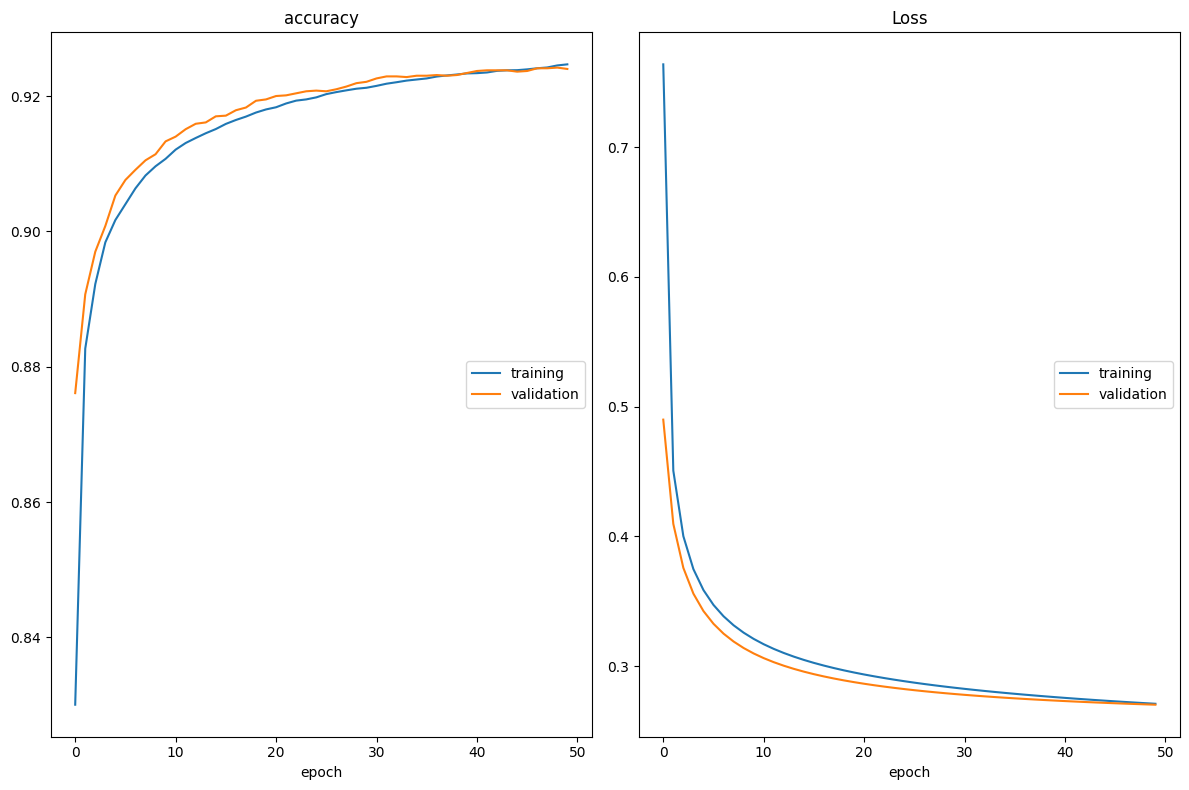

accuracy
	training         	 (min:    0.830, max:    0.925, cur:    0.925)
	validation       	 (min:    0.876, max:    0.924, cur:    0.924)
Loss
	training         	 (min:    0.271, max:    0.764, cur:    0.271)
	validation       	 (min:    0.270, max:    0.490, cur:    0.270)
Accuracy: 0.9240 (valid), 0.9247 (train)


In [23]:
# Run training
trained_model = train(slp, loss_fn, optimizer, train_loader, valid_loader)

In [25]:
test_loss, test_accuracy = evaluate_model(slp, loss_fn, test_loader)
print(test_loss)
print(test_accuracy)

0.27408043420314787
0.9225


<!-- JPN -->
　…ところで、学習速度はどのように変わっただろうか。GPUを使ってどの程度高速化されただろうか。実は今回の場合、1つの予測を行うのに必要な計算が少ないため、GPUを効果的に使うことができない。課題やこの後の説明で使う多層パーセプトロンでは、GPUを使わないと話にならないくらい遅くなってしまうので、先に説明している。

<!-- ENG -->
　...By the way, how has the training speed changed? How much faster could it be if using the GPU? In fact, in this case, the GPU cannot be used effectively because the number of calculations required to make a single prediction is small.
In the the following exercises and lectures, the training speed will become too slow without using the GPU, so please understand that you have been taught in advance.


<!-- JPN -->
　（2021年11月追記）昨今、Google Colaboratory上でのGPU利用制限が厳しくなりつつある。特に、**一定期間内のGPU利用時間の上限が定められている。**このため、この後の課題を行う際にGPUが使えない、という問題が発生しうる。
このような場合には、（根本的な対策ではないが）**Googleアカウントを追加作成し、新たなアカウント上でGoogle Colabを利用するなどで一時的に対応**することが可能である。

<!-- ENG -->
　(Added November 2021) Recently, restrictions on the use of GPUs on Google Colaboratory are becoming stricter. In particular, **there is a limit to the amount of time you can use the GPU within a certain period of time**. As a result, there may be a problem that the GPU cannot be used for the following exercises.
In such a case, **it is possible (though not permanent) to temporarily deal with the problem by creating an additional Google account and using Google Colab with the new account**.

-----

<!-- JPN -->
##### 課題 1

　これまでのコードで、784次元の画像データから10クラスの確率を出力する**単層の**パーセプトロンを構築した。

　今度は**多層の**パーセプトロンを構築し、予測を行ってみよう。（入力 28×28 → 512 → 256 → 10 出力）となるような多層パーセプトロンを構築し、実際に学習を行うことで、50 epoch後の訓練データに対する正解率 (accuracy) `mlp_train_accuracy`、検証データに対する正解率 `mlp_valid_accuracy` 、およびテストデータに対する正解率 `mlp_test_accuracy` を求めよ。

<!-- ENG -->
##### Exercise 1

　With the code so far, we have built a **single-layer** perceptron that outputs 10 classes of probabilities from 784 dimensional image data.

　Now let's try to build a **multi-layer** perceptron to make predictions. Construct a multilayer perceptron such that [input 28×28 → 512 → 256 → 10 outputs], and provide an answer for the accuracy ratio of the training data `mlp_train_accuracy`, the validation data `mlp_valid_accuracy`, and the test data `mlp_test_accuracy` after 50 epochs of training.

![Figure 4](https://i.imgur.com/qB1Cdcz.png)

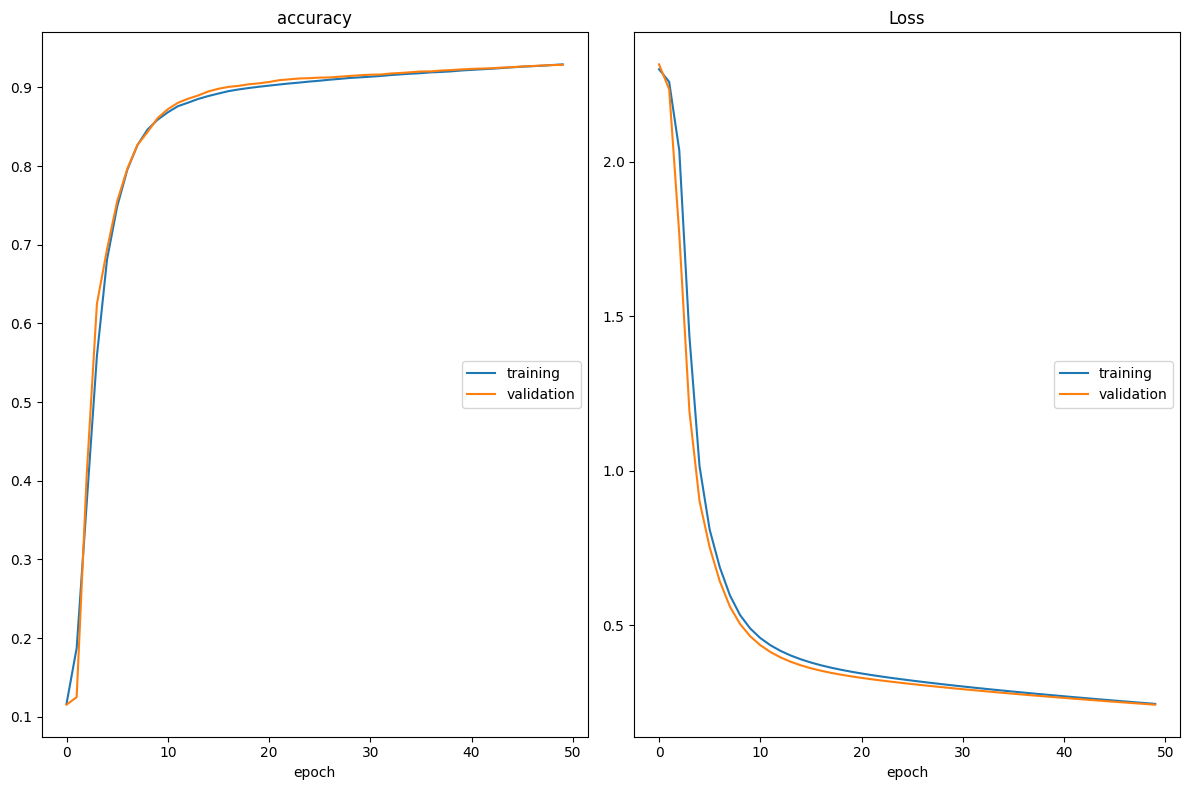

accuracy
	training         	 (min:    0.116, max:    0.929, cur:    0.929)
	validation       	 (min:    0.115, max:    0.929, cur:    0.929)
Loss
	training         	 (min:    0.245, max:    2.300, cur:    0.245)
	validation       	 (min:    0.243, max:    2.316, cur:    0.243)
Accuracy: 0.9286 (valid), 0.9292 (train)
Accuracy for training data: 0.9290
Accuracy for validation data: 0.9286
Accuracy for test data: 0.9286


In [26]:
# CODE CELL FOR YOUR ANSWER

torch.manual_seed(0) # Ensure reproducibility of training results
torch.backends.cudnn.deterministic = True # Fix the calculation result on the GPU side

mlp = torch.nn.Sequential(
  torch.nn.Linear(28*28, 512),
  torch.nn.Sigmoid(),
  torch.nn.Linear(512, 256),
  torch.nn.Sigmoid(),
  torch.nn.Linear(256, 10),
)
mlp.cuda() # Transfer the model to the GPU

# Prepare loss functions and optimization methods
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mlp.parameters(), lr=0.1)

# Run training
trained_model = train(mlp, loss_fn, optimizer, train_loader, valid_loader)

# Run evaluations
mlp_train_loss, mlp_train_accuracy = evaluate_model(mlp, loss_fn, train_loader)
mlp_valid_loss, mlp_valid_accuracy = evaluate_model(mlp, loss_fn, valid_loader)
mlp_test_loss, mlp_test_accuracy = evaluate_model(mlp, loss_fn, test_loader)
print(f"Accuracy for training data: {mlp_train_accuracy:.4f}")
print(f"Accuracy for validation data: {mlp_valid_accuracy:.4f}")
print(f"Accuracy for test data: {mlp_test_accuracy:.4f}")

-----

<!-- JPN -->
##### 課題 2（実践、提出不要）

　`update_model()` 関数と `evaluate_model()` 関数は、よくよく見てみると非常に似ている。これらを関数をまとめて、引数に応じてモデルの更新およびモデルの評価を行う `calculate_model()` 関数を作成せよ。

　関数を作成したら、この関数を用いた学習を行い、結果がほとんど変わらないことを確認せよ。


<!-- ENG -->
##### Exercise 2 (Practical, not required to submit)

　The `update_model()` functions and `evaluate_model()` functions are very similar if you look at them closely. Put these functions together to create the `calculate_model()` function, which updates and evaluates the model according to its arguments.

　Once you have created the function, perform training using this function and check that the results are almost the same.

---------

<!-- JPN -->
## 3 | 勾配消失問題とその対策

<!-- ENG -->
## 3 | Vanishing gradient problem and its countermeasures

<!-- JPN -->
　ニューラルネットワークは、多層にすることで複雑な関数を表現できることを学んできた（直前の演習では、単層に比べて多層にすることで精度が向上するはずである）。

　一方、層をとりあえず深くしておけば、精度が向上するとは限らない。層が深くなりすぎた場合に、誤差逆伝播が殆ど機能しなくなる、「**勾配消失問題**」という問題があるためである。

　実際に、8層のモデルを利用して試してみよう。これはかなり層が深いモデルであると言える。

<!-- ENG -->
　We have learned that neural networks can represent complex functions by using multiple layers (in the previous exercise, the accuracy should have been improved by using multiple layers compared to a single<sub> </sub>layer).

　On the other hand, making the layer deeper does not always necessarily improve the accuracy. This is because there is a problem called the "**vanishing gradient problem**" where backpropagation becomes almost non-functional when the layer becomes too deep.

　Let's actually confirm this using an 8-layer model. This is a very deep layered model.

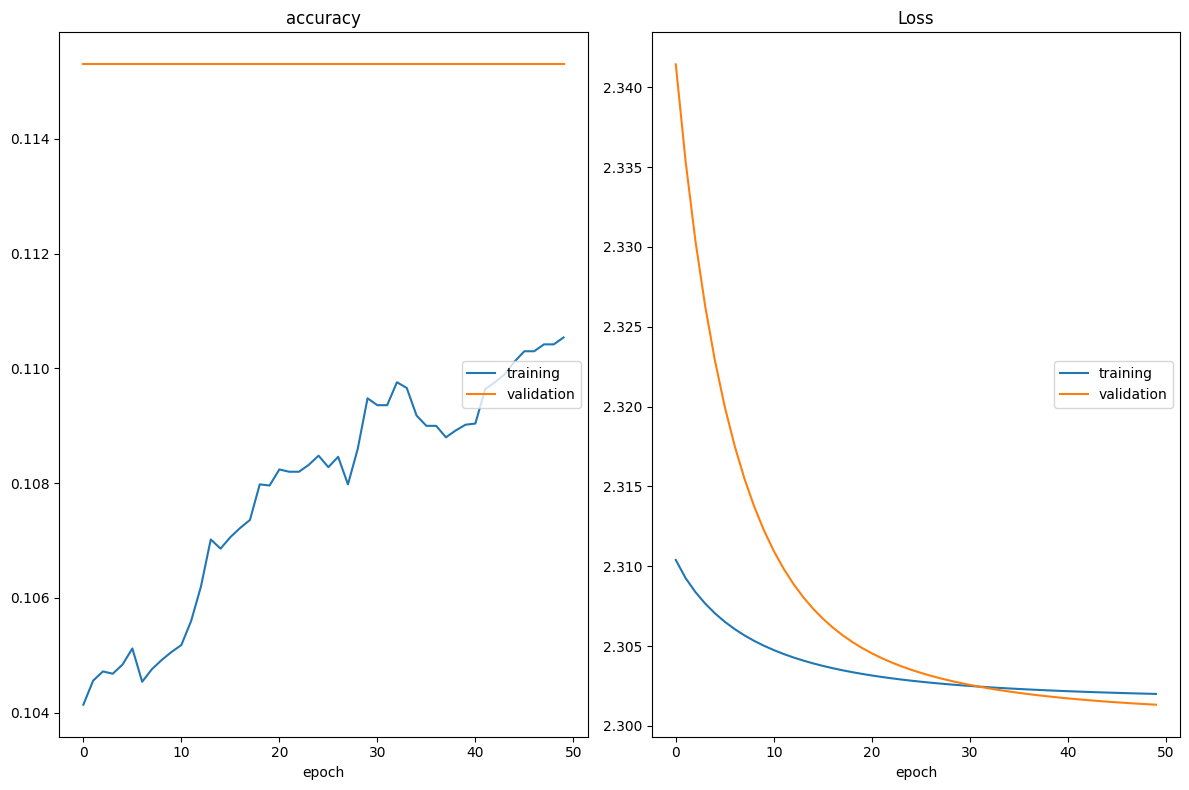

accuracy
	training         	 (min:    0.104, max:    0.111, cur:    0.111)
	validation       	 (min:    0.115, max:    0.115, cur:    0.115)
Loss
	training         	 (min:    2.302, max:    2.310, cur:    2.302)
	validation       	 (min:    2.301, max:    2.341, cur:    2.301)
Accuracy: 0.1153 (valid), 0.1105 (train)
2.302072587966919
0.1135


In [27]:
###### A trick that makes the final result the same value every time ######
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True

model = torch.nn.Sequential(
  torch.nn.Linear(28*28, 512),
  torch.nn.Sigmoid(),
  torch.nn.Linear(512, 512),
  torch.nn.Sigmoid(),
  torch.nn.Linear(512, 512),
  torch.nn.Sigmoid(),
  torch.nn.Linear(512, 512),
  torch.nn.Sigmoid(),
  torch.nn.Linear(512, 512),
  torch.nn.Sigmoid(),
  torch.nn.Linear(512, 512),
  torch.nn.Sigmoid(),
  torch.nn.Linear(512, 256),
  torch.nn.Sigmoid(),
  torch.nn.Linear(256, 10),
)
model.cuda() # Transfer the model to the GPU

# Prepare loss functions and optimization methods
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Run training
trained_model = train(model, loss_fn, optimizer, train_loader, valid_loader)

# Run predictions
test_loss, test_accuracy = evaluate_model(model, loss_fn, test_loader)
print(test_loss)
print(test_accuracy)

<!-- JPN -->
　このように、学習がほとんど進まないという状況が発生する（正解率が10%台であることに注意せよ）。これは、**シグモイド関数の微分値の最大値が1/4**であり、さらに**微分値がほぼ0である領域が非常に広い**ことに起因している（cf. **誤差逆伝播の計算における計算グラフの処理は掛け算の繰り返し**であることを思い出せ）。

　これを回避する方法として、ReLU (Rectified Linear Unit) という活性化関数がよく用いられている。これは $\mathrm{ReLU}(x) = \max(0, x)$ で表される関数で、**$x$ が正であれば微分値はどこまでも1**である。

<!-- ENG -->
　A situation arises such as this where little or no progress is made in training (note that the accuracy is in the 10% range). This is due to the fact that **the maximum derivative of the sigmoid function is 1/4**, and in addition, **the region where the derivative is almost zero is very large** (cf. **Recall that the computational graph process in the calculation of backpropagation is multiplication iteration**).



　As a way to avoid this, an activation function called ReLU (Rectified Linear Unit) is often used. This is the function expressed by $\mathrm{ReLU}(x) = \max(0, x)$, where the derivative is **always 1 as long as $x$ is positive**.

![Figure 5](https://i.imgur.com/VsfdLcp.png)

<!-- JPN -->
**誤差逆伝播** | $\Sigma, \sigma, H$ はそれぞれ総和、シグモイド関数、交差エントロピー損失を意味する。

<!-- ENG -->
**Backpropagation** | $\Sigma, \sigma, H$ refer to the sum, sigmoid function, and cross entropy loss, respectively.

![Figure 6](https://i.imgur.com/vZ3edOO.png)

<!-- JPN -->
**Sigmoid関数とReLU関数** | 関数の傾きの差を見るために、同一縮尺で描画した。


<!-- ENG -->
**Sigmoid function and ReLU function** | These are drawn at the same scale to see the difference in slope between the two.


<!-- JPN -->
　同じ8層のモデルについて、 `Sigmoid()` の代わりに `ReLU()` を使って学習させてみる。なお、ReLUの場合はSigmoidを使う場合に比べて少し学習率を下げておくと良いだろう。

<!-- ENG -->
　For the same 8-layer model, let's try to train it using `ReLU()` instead of `Sigmoid()`. In the case of ReLU, it is recommended to reduce the learning rate a little as compared to when using Sigmoid.

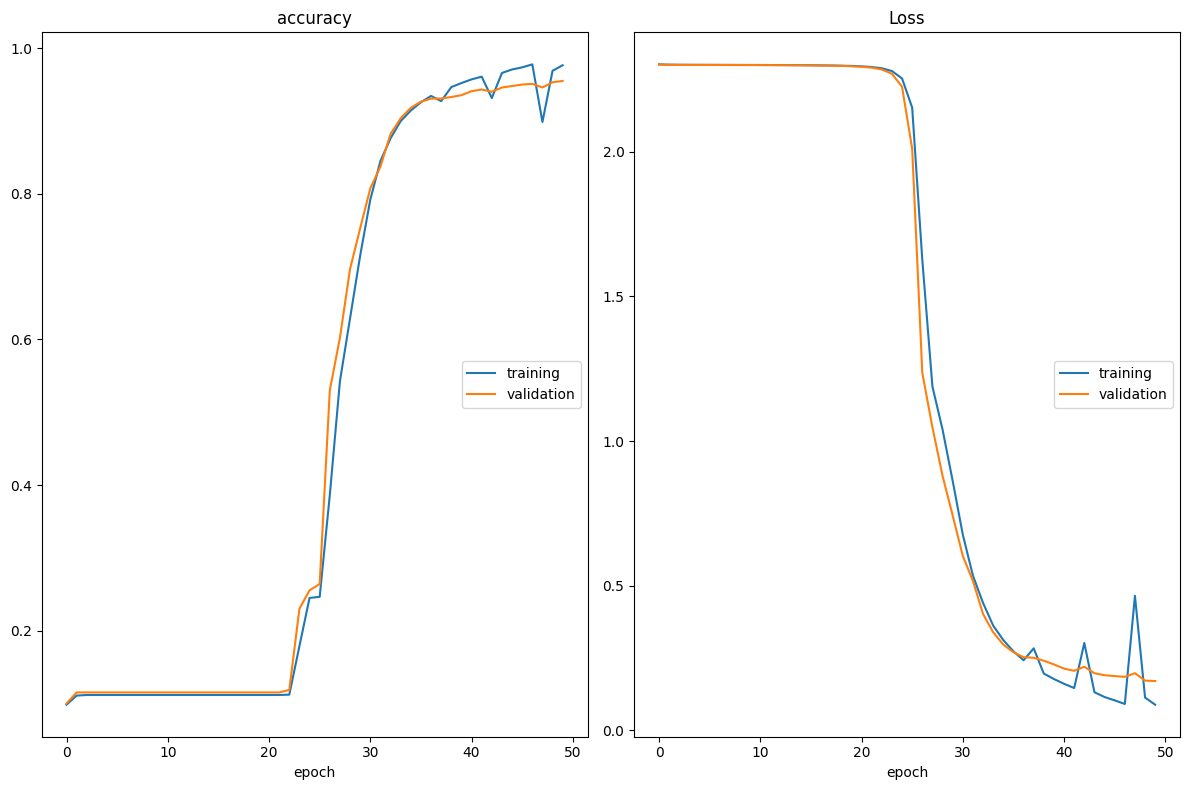

accuracy
	training         	 (min:    0.098, max:    0.978, cur:    0.977)
	validation       	 (min:    0.100, max:    0.955, cur:    0.955)
Loss
	training         	 (min:    0.088, max:    2.303, cur:    0.088)
	validation       	 (min:    0.170, max:    2.302, cur:    0.170)
Accuracy: 0.9550 (valid), 0.9765 (train)
0.1874902448862791
0.9502


In [28]:
###### A trick that makes the final result the same value every time ######
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True

model = torch.nn.Sequential(
  torch.nn.Linear(28*28, 512),
  torch.nn.ReLU(),
  torch.nn.Linear(512, 512),
  torch.nn.ReLU(),
  torch.nn.Linear(512, 512),
  torch.nn.ReLU(),
  torch.nn.Linear(512, 512),
  torch.nn.ReLU(),
  torch.nn.Linear(512, 512),
  torch.nn.ReLU(),
  torch.nn.Linear(512, 512),
  torch.nn.ReLU(),
  torch.nn.Linear(512, 256),
  torch.nn.ReLU(),
  torch.nn.Linear(256, 10),
)
model.cuda() # Transfer the model to the GPU

# Prepare loss functions and optimization methods
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.02) # Lower the learning rate to 1/5

# Run training
trained_model = train(model, loss_fn, optimizer, train_loader, valid_loader)

# Run predictions
test_loss, test_accuracy = evaluate_model(model, loss_fn, test_loader)
print(test_loss)
print(test_accuracy)

<!-- JPN -->
　最初こそ予測精度は向上していなかったが、20epochあたりから急激に正解率が向上、適切なモデルが構築できていることがわかる。ただ、時々大きく汎化性能が悪化することがあるため、どのepochが最も汎化性能が高いかをしっかり把握しておく必要がある（**補足資料 ※3**）。 `train()` 関数の中で、検証データに対する損失が最も小さかったモデルを記録しておくなどのコードの修正が必要だろう。

<!-- ENG -->
　At the beginning, the prediction accuracy did not improve, but after about 20 epochs, the accuracy improved rapidly, indicating that an appropriate model could be constructed. However, since generalization performance can sometimes deteriorate significantly, it is necessary to have a strong grasp of which epoch has the best generalization performance (**Supplementary Material S3**). It would be necessary to modify the code in the `train()` function to record the model that had the least loss for the validation data.

-----


<!-- JPN -->
##### 課題 3

　`torch.nn.ReLU()` 関数の派生として、`torch.nn.PReLU()` という活性化関数が存在する。どのような活性化関数か調べて簡潔にまとめよ（講義で習ったLeaky ReLUとの違いを明確にせよ）。

<!-- ENG -->
##### Exercise 3

　As a derivative of the `torch.nn.ReLU()` function, there is an activation function called `torch.nn.PReLU()`. Find out what kind of activation function it is and summarize it briefly (make clear the difference from Leaky ReLU which you learned in the lecture).

<!-- JPN -->
<font color=orange> **このテキストセルをダブルクリックし答案を記述せよ。** </font>
<!-- この下の行から答案を記述 -->


<!-- ENG -->
<font color=orange> **Double-click this text cell and write your answer.** </font>
<!-- From the next line, write your answer -->
The `torch.nn.PReLU()` function is a variant of the ReLU activation with learnable parameters. Unlike Leaky ReLU, PReLU introduces a parameter that allows the negative slope to be learned during training. This enables the network to adaptively determine the optimal slope for each neuron, potentially improving model performance.

-----


<!-- JPN -->
##### 課題 4

　前述の（8層からなる）モデルについて、全ての活性化関数を`torch.nn.PReLU()`に取り換えて学習を行い、テストデータに対する正解率 `mlp_prelu_test_accuracy` を比率で答えよ。

<!-- ENG -->
##### Exercise 4

　For the aforementioned (8-layers) model, replace all activation functions with `torch.nn.PReLU()`, train it, and answer the accuracy ratio for the test data `mlp_prelu_test_accuracy`.

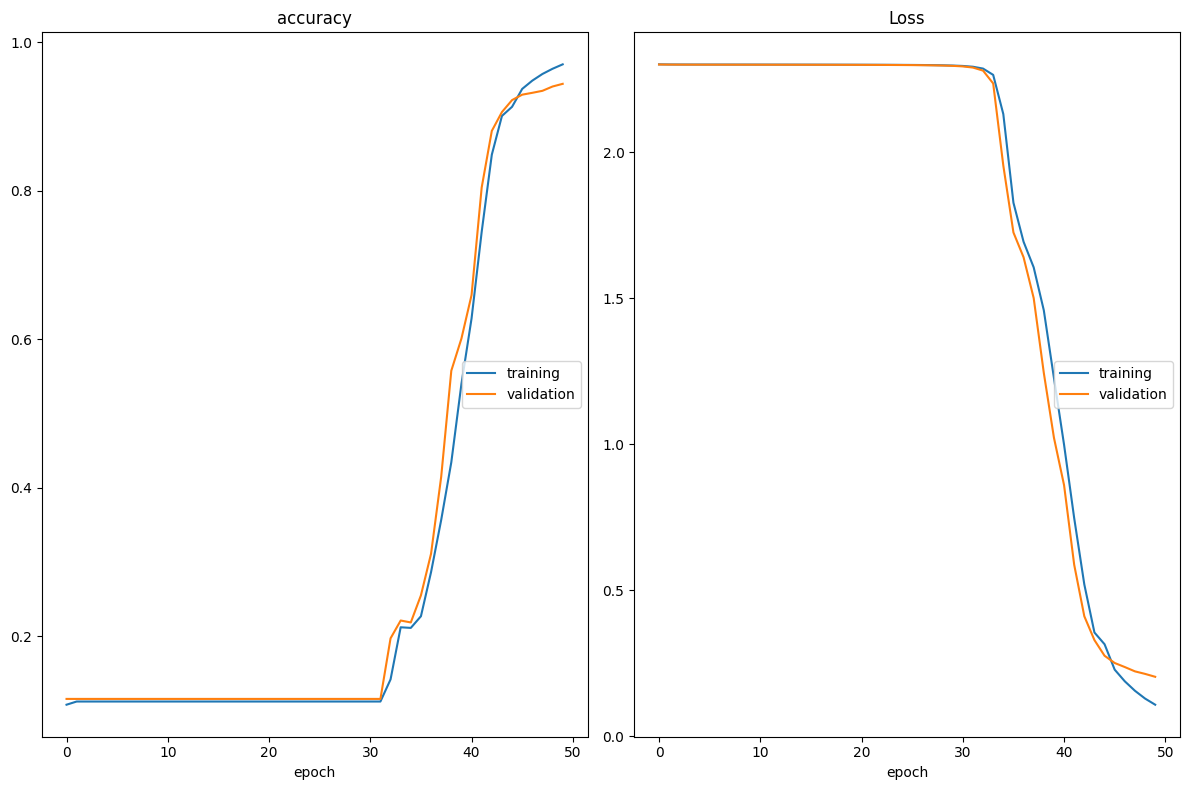

accuracy
	training         	 (min:    0.107, max:    0.970, cur:    0.970)
	validation       	 (min:    0.115, max:    0.944, cur:    0.944)
Loss
	training         	 (min:    0.107, max:    2.302, cur:    0.107)
	validation       	 (min:    0.203, max:    2.301, cur:    0.203)
Accuracy: 0.9438 (valid), 0.9700 (train)
0.221424422557652
0.943


In [29]:
# CODE CELL FOR YOUR ANSWER

###### A trick that makes the final result the same value every time ######
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True

model = torch.nn.Sequential(
  torch.nn.Linear(28*28, 512),
  torch.nn.PReLU(),
  torch.nn.Linear(512, 512),
  torch.nn.PReLU(),
  torch.nn.Linear(512, 512),
  torch.nn.PReLU(),
  torch.nn.Linear(512, 512),
  torch.nn.PReLU(),
  torch.nn.Linear(512, 512),
  torch.nn.PReLU(),
  torch.nn.Linear(512, 512),
  torch.nn.PReLU(),
  torch.nn.Linear(512, 512),
  torch.nn.PReLU(),
  torch.nn.Linear(512, 256),
  torch.nn.PReLU(),
  torch.nn.Linear(256, 10),
)

model.cuda() # Transfer the model to the GPU

# Prepare loss functions and optimization methods
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.02)

# Run training
trained_model = train(model, loss_fn, optimizer, train_loader, valid_loader)

# Run predictions
mlp_prelu_test_loss, mlp_prelu_test_accuracy = evaluate_model(model, loss_fn, test_loader)
print(mlp_prelu_test_loss)
print(mlp_prelu_test_accuracy)

-----

<!-- JPN -->
## 4 | Dropoutによる正則化

　活性化関数 `ReLU()` を用いることで、層を深くすることに成功した。一般に、層を深く、一層あたりのニューロン数（次元数）を大きくした方が複雑な関数を表現しやすくなる。
一方で、複雑な関数を表現できるということは、過学習 (overfitting) を起こしやすい、ということでもある。
これに対して、過学習を抑える方策として **正則化** というものが存在する。
今回はニューラルネットワークでよく用いられる過学習防止手法の1つである **Dropout** を利用してみる。


<!-- ENG -->
## 4 | Regularization using Dropout

　By using the activation function `ReLU()`, we succeeded in making the layer deeper. In general, the deeper the layers and the larger the number of neurons (number of dimensions) per layer, the easier it is to represent complex functions.
On the other hand, the ability to represent complex functions also means that it is prone to overfitting.
**Regularization** is a countermeasure to overfitting. Here, we will try to use **Dropout**, which is one of the overfitting prevention methods often used in neural networks.


<!-- JPN -->
　Dropoutの導入自体は非常に簡単であり、modelの**活性化関数の後に**導入すればよい。ただし、なんでもかんでも入れればよいというわけではなく、**適切に**入れる必要がある（がこれは非常に難しい）。
今回は、何も検討せずに、3層のニューラルネットワークの全ての活性化関数の後にDropoutを導入してみよう。


<!-- ENG -->
　The implementation of Dropout itself is very simple, and can be implemented **after the activation function** of the model. However, it does not mean that it should be included for everything, it needs to be included **appropriately** (but this is very difficult to judge).
This time, without any consideration, let's introduce Dropout after every activation function in the three-layer neural network.


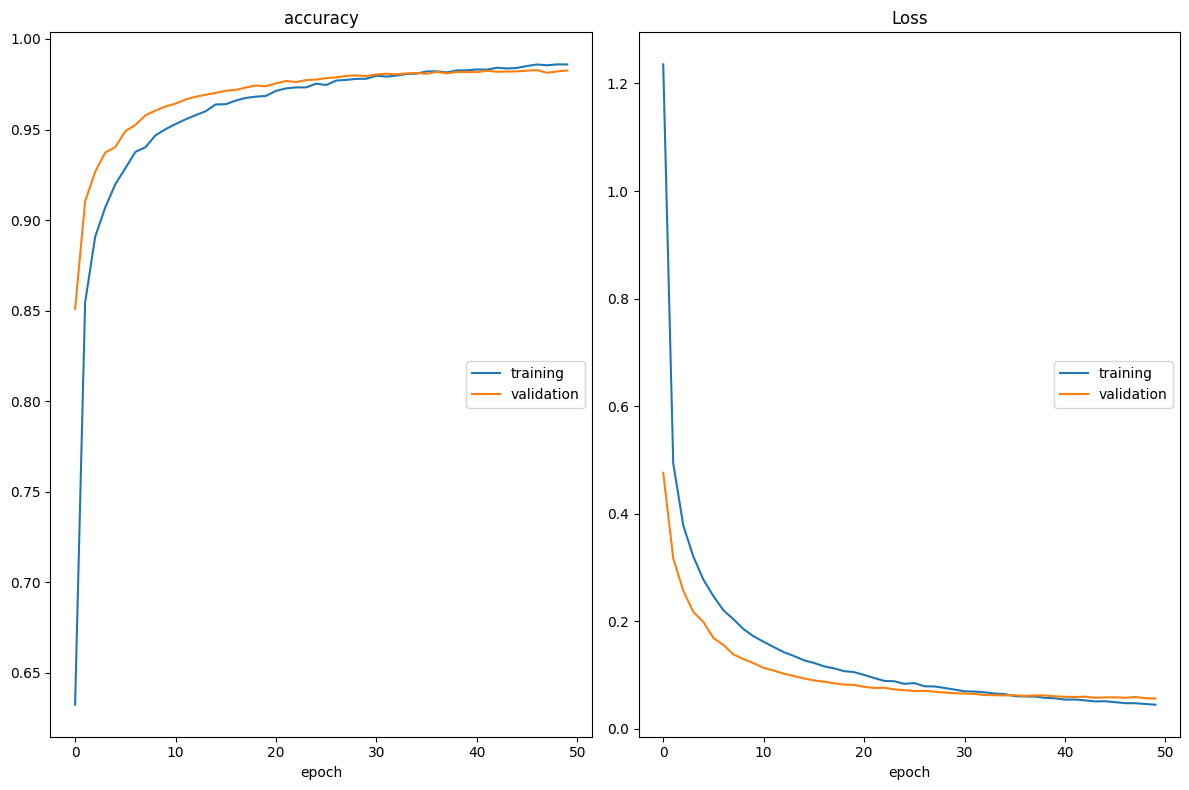

accuracy
	training         	 (min:    0.632, max:    0.986, cur:    0.986)
	validation       	 (min:    0.851, max:    0.983, cur:    0.983)
Loss
	training         	 (min:    0.045, max:    1.236, cur:    0.045)
	validation       	 (min:    0.057, max:    0.476, cur:    0.057)
Accuracy: 0.9826 (valid), 0.9859 (train)
0.055100463063479405
0.9837


In [30]:
###### A trick that makes the final result the same value every time ######
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True

model = torch.nn.Sequential(
  torch.nn.Linear(28*28, 512),
  torch.nn.ReLU(),
  torch.nn.Dropout(p=0.5),
  torch.nn.Linear(512, 256),
  torch.nn.ReLU(),
  torch.nn.Dropout(p=0.5),
  torch.nn.Linear(256, 10),
)
model.cuda() # Transfer the model to the GPU

# Prepare loss functions and optimization methods
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Run training
trained_model = train(model, loss_fn, optimizer, train_loader, valid_loader)

# Run predictions
test_loss, test_accuracy = evaluate_model(model, loss_fn, test_loader)
print(test_loss)
print(test_accuracy)

<!-- JPN -->
　**Dropoutは隠れ層の一部のニューロンをランダムに脱落させることで、同時に利用されるニューロン数（次元数）を削減し、過学習を抑える仕組み**である。ただし、一度に利用されるニューロン数を減少させることから**Dropoutは重み更新の回数を低下させる**ため、Dropoutを導入して学習を行う場合には、epoch数を増加させたり、学習率を上げるなど、十分に重み更新が行われるようにする必要がある。

<!-- ENG -->
　**Dropout is a mechanism that reduces the number of neurons (number of dimensions) used at the same time by randomly dropping some neurons in a hidden layer, thereby preventing overfitting**. However, since **Dropout reduces the number of weight updates** because the number of neurons used at one time decreases, it is necessary to ensure that the weights are updated sufficiently by increasing the number of epochs or the learning rate, etc., when Dropout is introduced to the model.

-----

<!-- JPN -->
##### 課題 5

　Dropout層を1層目の全結合層の後にのみ入れたモデル、およびDropout層を2層目の全結合層の後にのみ入れたモデルを構築し、Dropout層をどちらの層にも入れた場合のモデルと比較し、最良のモデルを3種類のモデルの中から答えよ。ただし、最良のモデルと2番目のモデルで正解率が0.2%以下の差しかない場合には「最良のモデルは決められない」とすること。

　なお、この課題は実行環境によって結果が変化する恐れがあるため、Google Colaboratory上で実行すること。

<!-- ENG -->
##### Exercise 5

　Additionally build two more models, a model with Dropout layer only after the first linear (full-connect) layer, and a model with Dropout layer only after the second linear (full-connect) layer, and compare with the models and the model with two Dropout layers. Provide your answer for the best model from the three types. Note that if there is only a difference of 0.2 % or less between the best model and the second best model in terms of the accuracy rate, answer "the best model cannot be determined".

　This assignment must be executed on Google Colaboratory, as the results may vary depending on the environment.

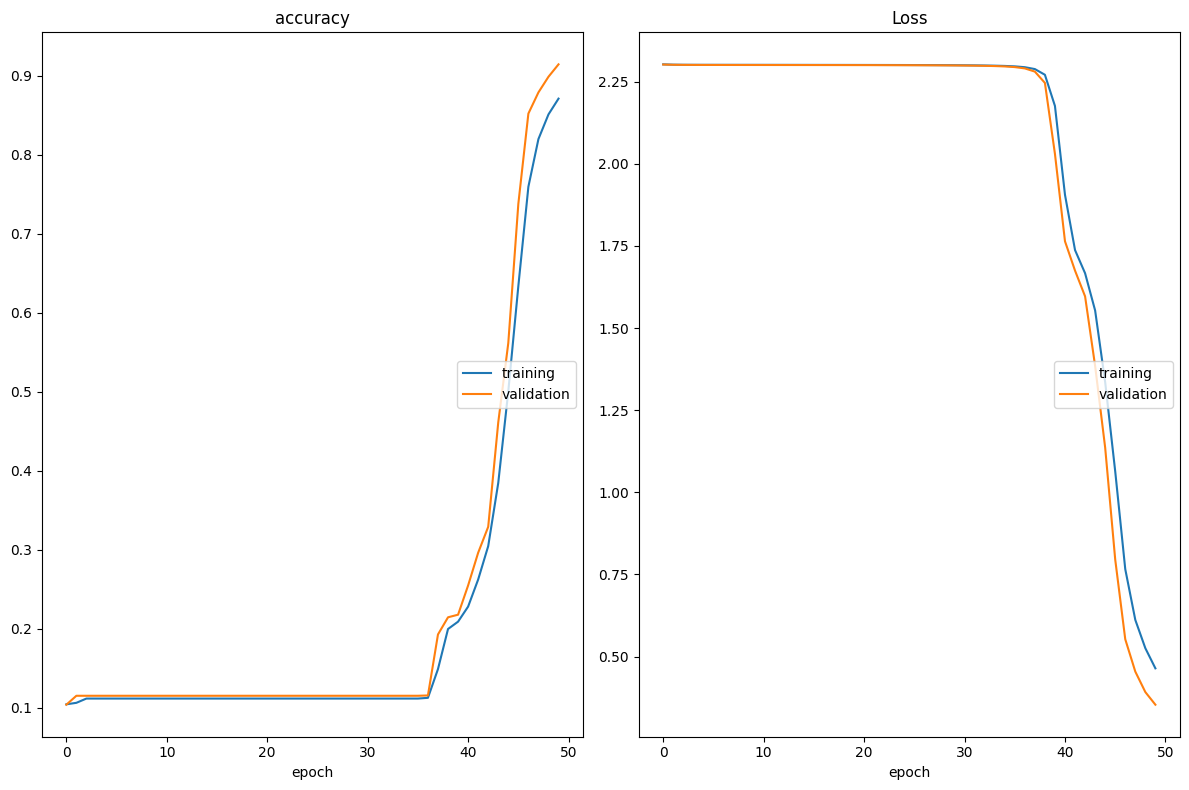

accuracy
	training         	 (min:    0.104, max:    0.871, cur:    0.871)
	validation       	 (min:    0.104, max:    0.914, cur:    0.914)
Loss
	training         	 (min:    0.464, max:    2.303, cur:    0.464)
	validation       	 (min:    0.354, max:    2.302, cur:    0.354)
Accuracy: 0.9143 (valid), 0.8709 (train)


In [38]:
# Set seed for reproducibility
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True

# Model with Dropout after the first linear layer
model_dropout_first = torch.nn.Sequential(
    torch.nn.Linear(28*28, 512),
    torch.nn.Dropout(0.5),  # Add Dropout after the first linear layer
    torch.nn.PReLU(),
    torch.nn.Linear(512, 512),
    torch.nn.PReLU(),
    torch.nn.Linear(512, 512),
    torch.nn.PReLU(),
    torch.nn.Linear(512, 512),
    torch.nn.PReLU(),
    torch.nn.Linear(512, 512),
    torch.nn.PReLU(),
    torch.nn.Linear(512, 512),
    torch.nn.PReLU(),
    torch.nn.Linear(512, 512),
    torch.nn.PReLU(),
    torch.nn.Linear(512, 256),
    torch.nn.PReLU(),
    torch.nn.Linear(256, 10),
)

model_dropout_first.cuda()

# Model with Dropout after the second linear layer
model_dropout_second = torch.torch.nn.Sequential(
    torch.nn.Linear(28*28, 512),
    torch.nn.PReLU(),
    torch.nn.Linear(512, 512),
    torch.nn.Dropout(0.5),  # Add Dropout after the second linear layer
    torch.nn.PReLU(),
    torch.nn.Linear(512, 512),
    torch.nn.PReLU(),
    torch.nn.Linear(512, 512),
    torch.nn.PReLU(),
    torch.nn.Linear(512, 512),
    torch.nn.PReLU(),
    torch.nn.Linear(512, 512),
    torch.nn.PReLU(),
    torch.nn.Linear(512, 512),
    torch.nn.PReLU(),
    torch.nn.Linear(512, 256),
    torch.nn.PReLU(),
    torch.nn.Linear(256, 10),
)

model_dropout_second.cuda()

# Model with Dropout after both the first and second linear layers
model_two_dropouts = torch.torch.nn.Sequential(
    torch.nn.Linear(28*28, 512),
    torch.nn.Dropout(0.5),  # Add Dropout after the first linear layer
    torch.nn.PReLU(),
    torch.nn.Linear(512, 512),
    torch.nn.Dropout(0.5),  # Add Dropout after the second linear layer
    torch.nn.PReLU(),
    torch.nn.Linear(512, 512),
    torch.nn.PReLU(),
    torch.nn.Linear(512, 512),
    torch.nn.PReLU(),
    torch.nn.Linear(512, 512),
    torch.nn.PReLU(),
    torch.nn.Linear(512, 512),
    torch.nn.PReLU(),
    torch.nn.Linear(512, 512),
    torch.nn.PReLU(),
    torch.nn.Linear(512, 256),
    torch.nn.PReLU(),
    torch.nn.Linear(256, 10),
)

model_two_dropouts.cuda()

# Prepare loss functions and optimization methods
loss_fn = torch.nn.CrossEntropyLoss()
optimizer_dropout_first = torch.optim.SGD(model_dropout_first.parameters(), lr=0.02)
optimizer_dropout_second = torch.optim.SGD(model_dropout_second.parameters(), lr=0.02)
optimizer_two_dropouts = torch.optim.SGD(model_two_dropouts.parameters(), lr=0.02)

# Assuming train_loader, valid_loader, and test_loader are defined
# Train models
trained_model_two_dropouts = train(model_two_dropouts, loss_fn, optimizer_two_dropouts, train_loader, valid_loader)

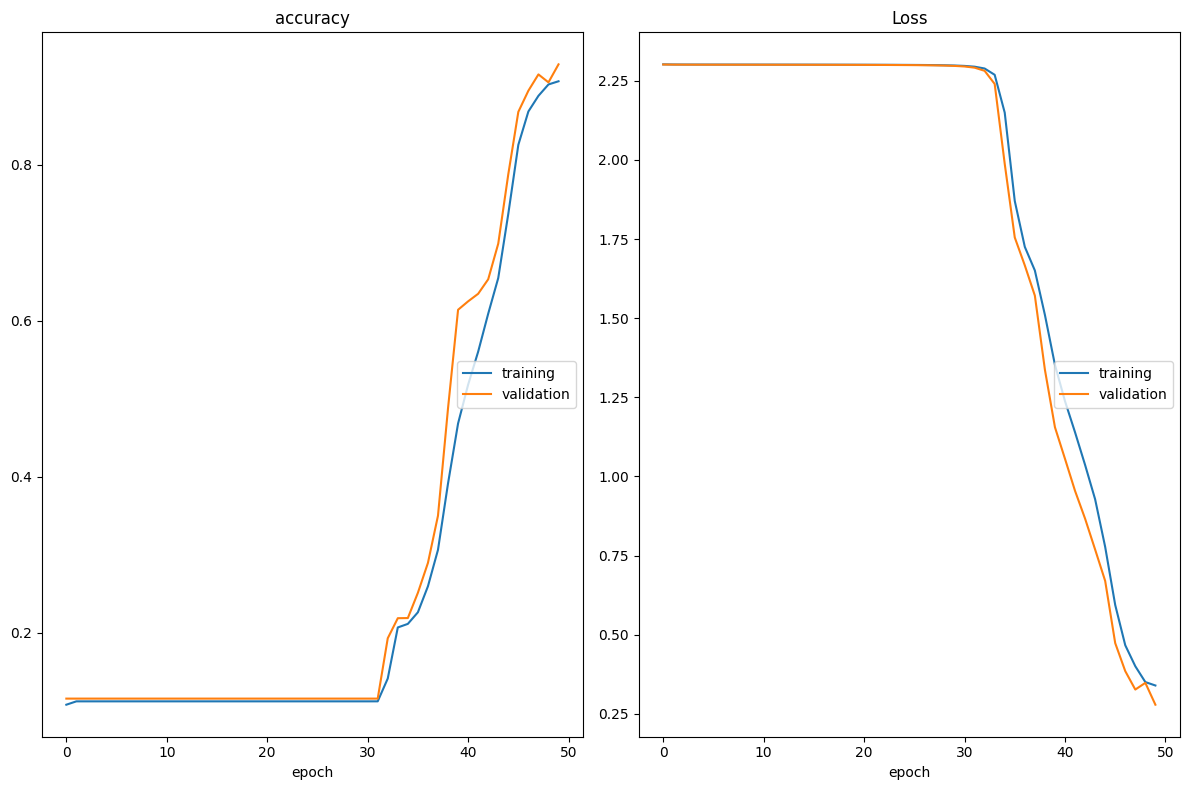

accuracy
	training         	 (min:    0.107, max:    0.907, cur:    0.907)
	validation       	 (min:    0.115, max:    0.929, cur:    0.929)
Loss
	training         	 (min:    0.340, max:    2.302, cur:    0.340)
	validation       	 (min:    0.279, max:    2.301, cur:    0.279)
Accuracy: 0.9286 (valid), 0.9069 (train)


In [42]:
trained_model_dropout_first = train(model_dropout_first, loss_fn, optimizer_dropout_first, train_loader, valid_loader)

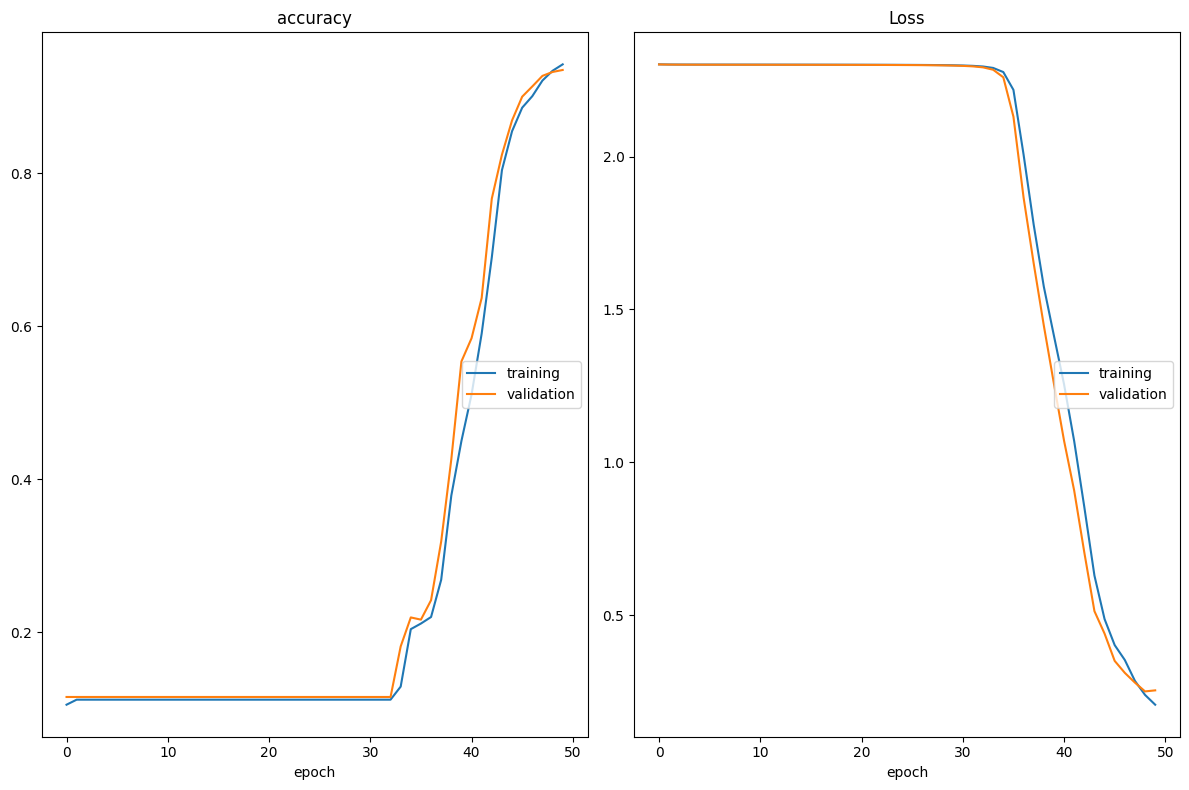

accuracy
	training         	 (min:    0.105, max:    0.942, cur:    0.942)
	validation       	 (min:    0.115, max:    0.935, cur:    0.935)
Loss
	training         	 (min:    0.207, max:    2.302, cur:    0.207)
	validation       	 (min:    0.251, max:    2.302, cur:    0.254)
Accuracy: 0.9350 (valid), 0.9424 (train)


In [40]:
trained_model_dropout_second = train(model_dropout_second, loss_fn, optimizer_dropout_second, train_loader, valid_loader)

In [43]:
# Evaluate models
test_loss_dropout_first, test_accuracy_dropout_first = evaluate_model(model_dropout_first, loss_fn, test_loader)
test_loss_dropout_second, test_accuracy_dropout_second = evaluate_model(model_dropout_second, loss_fn, test_loader)
test_loss_two_dropouts, test_accuracy_two_dropouts = evaluate_model(model_two_dropouts, loss_fn, test_loader)

print(test_accuracy_dropout_first,test_accuracy_dropout_second,test_accuracy_two_dropouts)

0.9287 0.9314 0.9097


<!-- JPN -->
<font color=orange> **このテキストセルをダブルクリックし答案を記述せよ。** </font>
<!-- この下の行から答案を記述 -->


<!-- ENG -->
<font color=orange> **Double-click this text cell and write your answer.** </font>
<!-- From the next line, write your answer -->
The best model cannot be determined.

-------

<!-- JPN -->
##### 課題 6

　課題 5の結論に至った理由を記述せよ。理由として、訓練データ、検証データ、テストデータのどのデータに対する正解率を用いて判断したかを明記すること。

<!-- ENG -->
##### Exercise 6

　Provide the reason of answer of Exercise 5. Describe which accuracy (accuracy for training data, accuracy for validation data, or accuracy for test data) was used to make the decision.

<!-- JPN -->
<font color=orange> **このテキストセルをダブルクリックし答案を記述せよ。** </font>
<!-- この下の行から答案を記述 -->


<!-- ENG -->
<font color=orange> **Double-click this text cell and write your answer.** </font>
<!-- From the next line, write your answer -->

Considering both validation and training accuracies, it appears that the Model with Dropout after the second layer (93.50% (valid), 94.24% (train), 93.14% (test) difference between it and second best model (Dropout after the first layer: 92.87%) more than 0.2%) is performing better on train, valid and test data, which is typically a good indicator of generalization to unseen data.

-------

<!-- JPN -->
# 補足資料


<!-- ENG -->
# Supplementary Material


<!-- JPN -->
## ※1 なぜ `evaluate()` を行う際に`model.eval()`が必要なのか
　Dropoutなど、学習と予測で異なる動作をする層が存在する（Dropoutの挙動については基盤人工知能 第6回 資料参照のこと）。そのため、重みの更新を行わないようにするだけでは不十分であり、`eval()`状態にする必要がある。

<!-- ENG -->
## S1 Why `evaluate()` requires `model.eval()`
　There are some layers, such as Dropout, that behave differently with training and prediction (for Dropout's behavior, please refer to the material in Fundamentals of Artificial Intelligence ⑥). Therefore, it is not enough to prevent the weights from being updated, it is necessary to put in the `eval()` state.

<!-- JPN -->
## ※2 | Google ColaboratoryにおけるGPUの利用

　今回授業資料として配布したJupyter Notebookは**GPU利用設定がすでにONになっており**、追加の設定なくGPUを使うことができる。一方、Google Colaboratoryの初期設定はGPU利用がOFFになっているので、ONにする方法を紹介する（以下の資料は[Chainer tutorialの「1.3.5. GPUを利用する」](https://tutorials.chainer.org/ja/01_Welcome_to_Chainer_Tutorial.html#GPU-%E3%82%92%E4%BD%BF%E7%94%A8%E3%81%99%E3%82%8B)から引用・一部修正している）。

<!-- ENG -->
## S2 | Use of GPUs in Google Colaboratory

　In the Jupyter Notebook that was distributed as class material this time, **the GPU usage setting is already turned ON**, so you can use the GPU without any additional settings. On the other hand, the use of GPU is turned OFF in the default setting of Google Colaboratory, so the following will show you how to turn it ON (the following materials are quoted and partially modified from ["1.3.5. Using GPU" in Chainer tutorial](https://tutorials.chainer.org/ja/01_Welcome_to_Chainer_Tutorial.html#GPU-%E3%82%92%E4%BD%BF%E7%94%A8%E3%81%99%E3%82%8B)).

<!-- JPN -->
　まず、画面上部のタブの中の 「ランタイム」 (Runtime) をクリックし、「ランタイムのタイプを変更」 (Change runtime type) を選択する。

　すると、「ノートブックの設定」 (Notebook Settings) というものが表示されるはずである。この中の「ハードウェア アクセラレータ」 (Hardware Accelerator)をNoneからGPUに変更して、保存すればよい。

<!-- ENG -->
　First, click on "Runtime" from the tab at the top of the screen, and select “Change runtime type”.

　You should now see "Notebook settings". In this section, change the Hardware accelerator from “None” to “GPU”, and save it.

![Notebook settings](https://i.imgur.com/0YfFPmN.png)

<!-- JPN -->
## ※3 `ReLU()` を用いる時の注意点

　実際の実行で示したように、`ReLU()`を用いることで学習がかなり効率化されている。一方、予測結果がしばしば極端になるようで、例えば99.99%以上の極めて高確率で正例、と予測したデータが実際には負例であった時などに
 損失関数の値がとても大きな値になり、一時的に予測精度が低下したり、場合によってはモデルの重みが発散してしまう。

　このような現象があるため、学習が正しく進行しているかどうか適宜確認し、うまくいっていない場合には学習率を下げるなどの対応をしよう。

<!-- ENG -->
## S3 Points to note when using `ReLU()`

　As shown in the actual execution, the training is much more efficient using `ReLU()`. On the other hand, the prediction results often seem to be extreme. For example, when the data predicted to be positive with an extremely high probability of 99.99% or more is actually negative, the loss function value becomes very large, and the prediction accuracy temporarily decreases, or in some cases, the weight of the model diverges.

　Because of this phenomenon, we should check if the training is progressing properly from time to time, and if it is not, we should reduce the learning rate.